
# Практическое задание 4. Бустинг и бэггинг

## Общая информация
Дата выдачи: 14.01.2024

Мягкий дедлайн: 28.01.2024 23:59 MSK

Жёсткий дедлайн: 04.02.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. 

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-04-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Работать мы будем на двух наборах данных: многомерных данных по кредитам с kaggle и синтетических двумерных. В данных с kaggle целевая переменная показывает, вернуло ли кредит физическое лицо:

In [673]:
import numpy as np
import pandas as pd
import plotly.express as px
import random

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import BaggingClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

In [645]:
pd.set_option('display.max_columns', None)

In [218]:
!wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

In [417]:
df = pd.read_csv('bank_data.csv')
df.sample(5)

age            job  marital            education  default housing loan  \
7679   29     technician   single          high.school       no     yes   no   
4869   26    blue-collar  married             basic.9y  unknown      no  yes   
8224   36     management  married    university.degree       no     yes   no   
1189   47         admin.   single    university.degree       no     yes   no   
871    30  self-employed  married  professional.course       no      no   no   

        contact month day_of_week  ...  campaign  pdays  previous  \
7679  telephone   jun         wed  ...         1    999         0   
4869  telephone   jun         thu  ...         2    999         0   
8224   cellular   may         mon  ...         1    999         1   
1189   cellular   aug         thu  ...         4    999         0   
871   telephone   may         mon  ...         5    999         0   

         poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
7679  nonexistent         -1.7          94.055          -39.8      0.767   
4869  nonexistent          1.4          94.465          -41.8      4.866   
8224      failure         -1.8          92.893          -46.2      1.354   
1189  nonexistent          1.4          93.444          -36.1      4.968   
871   nonexistent          1.1          93.994          -36.4      4.857   

      nr.employed  y  
7679       4991.6 -1  
4869       5228.1 -1  
8224       5099.1  1  
1189       5228.1 -1  
871        5191.0 -1  

[5 rows x 21 columns]

Разделим на train и test (random_state не меняем)

In [220]:
#df['y'] = df['y'].replace(-1,0)

In [690]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

___OHE ENCODER___

In [691]:
encoder = OneHotEncoder()
encod_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

In [692]:
# test data
encoded_data = encoder.fit_transform(df_train[encod_columns]).toarray() # fit transform transform ohe
ohe_train = pd.DataFrame(encoded_data, columns= encoder.get_feature_names_out()) # ohe ndarray

#update train
df_train = df_train.drop(encod_columns, axis=1)
df_train = pd.concat([df_train.reset_index(drop=True), ohe_train], axis=1)

In [693]:
# train data
encoded_data = encoder.transform(df_test[encod_columns]).toarray()  # transform transform ohe
ohe_test =  pd.DataFrame(encoded_data, columns= encoder.get_feature_names_out()) # ohe ndarray

#update train
df_test = df_test.drop(encod_columns, axis=1)
df_test = pd.concat([df_test.reset_index(drop=True), ohe_test], axis=1)

In [698]:
X_train = df_train.drop('y', axis=1)
y_train = df_train['y']

X_test = df_test.drop('y', axis=1)
y_test = df_test['y']

Генерируем синтетические данные (seed не меняем)

In [419]:
np.random.seed(42)

num_obs = 10 ** 5
num_thresholds = 50

X_synthetic = np.random.normal(scale=3, size=[num_obs, 2])
x1_thresholds = np.random.choice(X_synthetic[:, 0], num_thresholds, False)
x2_thresholds = np.random.choice(X_synthetic[:, 1], num_thresholds, False)

gains = np.random.uniform(-0.4086, 0.5, size=[2 * num_thresholds, 1])
x1_thresholds_cond = [X_synthetic[:, 0] >= threshold for threshold in x1_thresholds]
x2_thresholds_cond = [X_synthetic[:, 1] >= threshold for threshold in x2_thresholds]

noise = np.random.uniform(-0.5, 0.5, size=num_obs)

y_synthetic_probits = np.sum(
    gains[:num_thresholds] * x1_thresholds_cond + gains[num_thresholds:] * x2_thresholds_cond, axis=0
) + noise
y_synthetic = np.sign(y_synthetic_probits)

X_train_synthetic, y_train_synthetic = X_synthetic[:int(num_obs * 0.8)], y_synthetic[:int(num_obs * 0.8)]
X_test_synthetic, y_test_synthetic = X_synthetic[int(num_obs * 0.8):], y_synthetic[int(num_obs * 0.8):]

px.histogram(x = y_synthetic_probits, nbins=100)

Некоторый полезный код для визуализации предсказаний (пригодится позже)

In [856]:
import matplotlib.pyplot as plt

def plot_predicts(model, features, targets, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
                  examples_density=0.01, steps=1000, num_ticks=6, title='', mode='classification'):
    '''
    Функция для визуализации предсказаний модели на двухмерной плоскости
    param model: обученная модель классификации или регрессии для двухмерных объектов
    param features: признаки выборки (a.k.a. X)
    param targets: целевая переменная выборки (a.k.a y)
    param x_lim: пределы для x
    param y_lim: пределы для y
    param examples_density: доля выборки, которая будет нарисована
    param steps: частота разбиения плоскости
    param num_ticks: число подписей на графике
    param title: заголовок графика
    param mode: режим 'classification' - вероятности положительного класса
                режим 'regression' - вещественная целевая переменная
    '''
    
    mask = np.random.choice([True, False], size=features.shape[0], 
                            p=[examples_density, 1.0 - examples_density])
    features_x = (features[mask, 0] - x_lim[0]) / (x_lim[1] - x_lim[0]) * steps
    features_y = (features[mask, 1] - y_lim[0]) / (y_lim[1] - y_lim[0]) * steps
    
    xs = np.linspace(x_lim[0], x_lim[1], steps)
    ys = np.linspace(y_lim[0], y_lim[1], steps)
    
    xs, ys = np.meshgrid(xs, ys)
    grid = np.stack([xs.flatten(), ys.flatten()], axis=1)
    if mode == 'classification':
        predicts = model.predict_proba(grid)[:, 1].reshape(steps, steps)
        #values = (targets[mask] == 1).astype(np.float)
        values = (targets[mask] == 1).astype(float)
    elif mode == 'regression':
        predicts = model.predict(grid).reshape(steps, steps)
        values = targets[mask]
    else:
        raise ValueError('Unknown mode')
    
    plt.figure(figsize=(10, 10))
    plt.imshow(predicts, origin='lower')
    plt.scatter(features_x, features_y, c=values, edgecolors='white', linewidths=1.5)
    plt.colorbar()
    
    plt.xticks(np.linspace(0, steps, num_ticks), np.linspace(x_lim[0], x_lim[1], num_ticks))
    plt.yticks(np.linspace(0, steps, num_ticks), np.linspace(y_lim[0], y_lim[1], num_ticks))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid()
    plt.show()

#### 1. (4 балла) Реализуйте бустинг для задачи бинарной классификации.

Поскольку градиентный бустинг обучается через последовательное создание моделей, может получиться так, что оптимальная с точки зрения генерализации модель будет получена на промежуточной итерации. Обычно для контроля такого поведения в методе `fit` передается также валидационная выборка, по которой можно оценивать общее качество модели в процессе обучения (желательно делать это каждую итерацию, но если ваша имплементация слишком медленная или ваше железо не тянет, можно делать это реже). Кроме того, нет смысла обучать действительно глубокую модель на 1000 деревьев и больше, если оптимальный ансамбль получился, к примеру, на 70 итерации и в течение какого-то количества итераций не улучшился - поэтому мы также задействуем early stopping при отсутствии улучшений в течение некоторого числа итераций.

In [1231]:
class Boosting:
    from sklearn.model_selection import train_test_split

    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: dict={'max_features': 0.1, 'max_depth' : 5},
        n_estimators: int=10,
        learning_rate: float=0.1,
        subsample: float=0.3,
        random_seed: int=228,
        custom_loss: list or tuple=None,
        use_best_model: bool=False,
        n_iter_early_stopping: int=None
    ):
        
        # Класс базовой модели
        self.base_model_class = base_model_class
        # Параметры для инициализации базовой модели
        self.base_model_params = base_model_params
        # Число базовых моделей
        self.n_estimators = n_estimators
        # Длина шага (которая в лекциях обозначалась через eta)
        self.learning_rate = learning_rate
        # Доля объектов, на которых обучается каждая базовая модель
        self.subsample = subsample
        # seed для бутстрапа, если хотим воспроизводимость модели
        self.random_seed = random_seed
        # Использовать ли при вызове predict и predict_proba лучшее
        # с точки зрения валидационной выборки число деревьев в композиции
        self.use_best_model = use_best_model
        # число итераций, после которых при отсутствии улучшений на валидационной выборке обучение завершается
        self.n_iter_early_stopping = n_iter_early_stopping
        
        # Плейсхолдер для нулевой модели
        self.initial_model_pred = None

        # Плейсхолдер для остатков
        self.residuals = []

        # Плейсхолдер флага об успешном обучении (для метода feature_importances_)
        self.fit_model_flg = 0
        
        # Список для хранения весов при моделях
        self.gammas = []
        
        # Создаем список базовых моделей
        self.models = [self.base_model_class(**self.base_model_params) for _ in range(self.n_estimators)]
        self.init_model = None
        
        # Если используем свою функцию потерь, ее нужно передать как список из loss-a и его производной
        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
            self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)
        
        
    def _fit_initial_model(self, X, y):
        """
        Функция для построения нулевой (простой) модели. Не забудьте взять логарифм, потому что сигмоида применяется
        уже к сумме предсказаний базовых моделей, а не к каждому предсказанию каждой модели по отдельности.
        Подойдёт константная модель, возвращающая самый популярный класс,
        но если хотите, можете сделать что-нибудь посложнее.

        //
        Не очень понял зачем логарифм, все и так "завелось"
        Так же пробовал внедрить бутстреп, но явно что то не правильно делал и в итоге получался какой то рандом-
        Я так понимаю, что для модели0 у нас был Петя класс1, остаток 0.45. Далее мы на Маше класс0 пытаемся предсказать 0.45
        И из за того, что классы разные - получается шляпа (точнее ничего не получается)
        """
        random.seed(self.random_seed)

        self.init_model = DecisionTreeClassifier(max_depth=1) # Пень классификации в качестве модели инициализации
        
        # Бутсреп - возьмем не все объекты (не получилось до окнца реализовать)
        #len_bootstrap_data = int(len(X) * self.subsample) # Кол-во объектов для выборки
        #INDEXES = random.choices(pd.DataFrame(X).index, k=len_bootstrap_data) 
        #X_train = X.loc[INDEXES]
        #y_train = y.loc[INDEXES]

        self.init_model.fit(X, y)

        self.initial_model_pred = self.init_model.predict_proba(X)[:,1]

        self.residuals.append(y - self.initial_model_pred)




    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, n_model: int, eval_set=None):
        """
        Функция для обучения одной базовой модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :param n_model: номер модели, которую хотим обучить
        :eval_set: кортеж (X_val, y_val) для контроля процесса обучения или None, если контроль не используется
        """  
        random.seed(self.random_seed)
        
        # Определим X и y для валидационных данных, если такие есть
        if eval_set is not None:
            X_val = eval_set[0]
            y_val = eval_set[1]

        best_loss = 1 # Тут будет минимальный лосс
        best_iter = 0 # Тут будет лучшая итерация (с минимальным лоссом)
        cnt_bad_iter = 0 # Переменная для подсчета итераций, когда мы не можем улучшить прогноз
        min_iter_to_stop = [] # Тут будут лежать итерации, которые мы пропустили из за срабатывания early_stopping

        for i in range(n_model):

            # Если мы не улучшаемся n_iter_early_stopping итераций - пропустим новый цикл
            if cnt_bad_iter == self.n_iter_early_stopping:
                min_iter_to_stop.append(i) # Запишем пропущенную итерацию
            
            # Стандартынй цикл обучения базового алгоритма
            else:
                self.models[i] = self.base_model_class(**self.base_model_params)

                # Бутсреп - возьмем не все объекты (не завелось у меня)
                #INDEXES = random.choices(X.index, k=len_bootstrap_data) 
                #X_train = X.loc[INDEXES] # 2. Новая выборка бутстреп
                #residuals[-1] = residuals[-1]#.loc[INDEXES]
                #resid_last_iter = residuals[-1]#.reset_index(drop=True)# bstp test

                # Тут реализованна gamma, которая очень портила предсказания на тесте (хотя веса для моделей были адекватные в диапазоне 0-1) :(
                #optimal_gamma = self._find_optimal_gamma(y, self.residuals[-1], pred_resid)
                #self.gammas.append(optimal_gamma)
                #resid = self.residuals[-1] - optimal_gamma * self.learning_rate * pred_resid

                self.models[i].fit(X, self.residuals[-1]) # Обучаем модель на остатках предыдущих моделей # 3. Новая выборкамодель на бутстреп

                pred_resid = self.models[i].predict(X) # Предсказываем на текущей модели (ошибку прошлой модели) # 4. Новые предсказаний на бутстреп

                resid = self.residuals[-1] - self.learning_rate * pred_resid # Учитываем новый алгоритм с шагом learning_rate

                self.residuals.append(resid) 
                
                # Блок с проверкой на валидации
                if eval_set is not None:
                    # Предсказания модели на инициализации
                    predict = np.zeros(X_val.shape[0])
                    predict = predict + self.init_model.predict_proba(X_val)[:,1]

                    # Учтем в predict предсказания каждой модели из обученных
                    for model_ in self.models[:i]:
                        predict = predict + model_.predict(X_val)
                    
                    # Посчитаем вероятности, получим предсказания и посчитаем лосс
                    predict_1_class = self.sigmoid(predict)
                    pred_int = np.array([-1 if x  < .5 else 1 for x in predict_1_class])
                    
                    loss = self.loss_fn(y_val, pred_int)
                    print(i, loss)

                    # Если получили лучший лосс
                    if loss < best_loss:
                        best_loss = loss
                        best_iter = i
                        cnt_bad_iter = 0
                    #Если не улучшили лосс
                    else:
                        cnt_bad_iter = cnt_bad_iter + 1
        
        # Если у нас накопилось n_iter_early_stopping - возмем только часть моделей
        if cnt_bad_iter == self.n_iter_early_stopping:
            # Возьмем модели вплоть до последней полезной (после которой идут bad_iter * cnt_bad_iter =  n_iter_early_stopping)
            if self.use_best_model:
                self.models = self.models[:best_iter] # обрежем self.models
            # Если не условились брать use_best_model - берем все обученные
            else:
                cnt_model_to_use = min(min_iter_to_stop) # Последняя обученная модель, потом не обучали новые алгоритмы
                self.models = self.models[:cnt_model_to_use] # обрежем self.models



    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list=(0.01, 1)):
        """
        Функция для поиска оптимального значения параметра gamma (коэффициент перед новой базовой моделью).
        :param y: вектор целевой переменной
        :param old_predictions: вектор суммы предсказаний предыдущих моделей (до сигмоиды)
        :param new_predictions: вектор суммы предсказаний новой модели (после сигмоиды)
        :param boudnaries: в каком диапазоне искать оптимальное значение ɣ (array-like объект из левой и правой границ)
        """
        # Определеяем начальные лосс и оптимальную гамму
        loss, optimal_gamma = self.loss_fn(y, old_predictions), 0
        # Множество, на котором будем искать оптимальное значение гаммы
        gammas = np.linspace(*boundaries, 100)
        # Простым перебором ищем оптимальное значение
        for gamma in gammas:
            predictions = old_predictions + gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                optimal_gamma = gamma
                loss = gamma_loss
        
        return optimal_gamma
        
        
    def fit(self, X, y, eval_set=None):
        """
        Функция для обучения всей модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :eval_set: кортеж (X_val, y_val) для контроля процесса обучения или None, если контроль не используется
        """
            
        self._fit_initial_model(X, y) # Обучение модели инициализации (по умолчанию пень классификации)

        self._fit_new_model(X, y, n_model=self.n_estimators, eval_set=eval_set) # Обучение базовых алгоритмов

        self.fit_model_flg = 1 # Флаг об успешном обучении
        
        print('Model fitted')


    def predict_proba(self, X: np.ndarray):
        """
        Функция для предсказания вероятностей классов обученной моделью бустинга
        :param X: матрица признаков
        """
        # Предсказания модели инициализации
        predict = np.zeros(X.shape[0])
        predict = predict + self.init_model.predict_proba(X)[:,1]

        # Учтем каждую базовую модель в пердсказании
        for model_ in self.models:
            predict = predict + model_.predict(X)

        # Вариант с gamma, который оказался хуже варианта без gamma
        #for i, model_ in enumerate(self.models):
        #    predict = predict + self.gammas[i] * model_.predict(X)
            
        # Нормализуем вероятности с сигмоидой
        predict_1_class = self.sigmoid(predict)
        # Получим вероятность 0 класса и создадим ndarray для вывода двух классов (класса -1 на самом деле)
        pred_0_class = np.ones(len(predict_1_class)) - predict_1_class
        matrix = np.stack((pred_0_class, predict_1_class)).T

        return matrix
        
    def predict(self, X: np.ndarray):
        """
        Функция для предсказания классов обученной моделью бустинга
        :param X: матрица признаков
        """
        # Поулчим предсказания (скоры для 1 класса)
        pred_proba = self.predict_proba(X)[:,1]
        # Переведем скоры в score in {-1, 1}
        pred_int = np.array([-1 if x  < .5 else 1 for x in pred_proba])

        return pred_int

            
        
    @property
    def feature_importances_(self):
        """
        Для бонусного задания номер 5.
        Функция для вычисления важностей признаков.
        Вычисление должно проводиться после обучения модели
        и быть доступно атрибутом класса. 
        """
        # Если обучение пройдено и базовывй алгоритм это дерево регрессионное (для других моделей не было времени реализовать (для логрег по весам, например))
        if (self.fit_model_flg==1) & (self.base_model_class==DecisionTreeRegressor):
        
            feature_imp_df = pd.DataFrame() # DF С важностями фичей для всех моделей, где индекс = важность фичи
            
            # Важность фичей каждомй модели положим в общий df feature_imp_df
            for model_ in self.models:
                iter_df = pd.DataFrame(model_.feature_importances_) 
                iter_df.index = X_train.columns

                feature_imp_df = pd.concat([feature_imp_df, iter_df], axis=1)

            # Суммируем важность признака
            featire_importance_boosting = feature_imp_df.sum(axis=1)

            # Нормаируем важность в диапазон от 0 до 1
            fi_sum = featire_importance_boosting.sum()
            featire_importance_boosting = featire_importance_boosting.apply(lambda x: x/fi_sum)

            return featire_importance_boosting


        
        elif self.fit_model_flg==0:
            print('Fit model before get feature importance!')

        else:
            print('feature_importances_ only for DecisionTreeRegressor in base model')

___Тест методов класса градиентного бустинга___

In [1239]:
# тестовый запуск 0
test_boosting = Boosting(n_estimators=200, n_iter_early_stopping=50, use_best_model=True, learning_rate=0.1)
test_boosting.fit(X_train, y_train, eval_set=(X_test, y_test))

0 0.827270308207878
1 0.5368608254492573
2 0.5325504806216711
3 0.567572032345809
4 0.5400935840699469
5 0.5476366875182228
6 0.5767315151044297
7 0.592895308207878
8 0.5982832392423607
9 0.5934341013113262
10 0.6015159978630503
11 0.5950504806216711
12 0.5664944461389124
13 0.567572032345809
14 0.583197032345809
15 0.5864297909664986
16 0.5902013426906365
17 0.5934341013113262
18 0.5896625495871883
19 0.5869685840699469
20 0.5885849633802918
21 0.5815806530354641
22 0.5810418599320158
23 0.5821194461389124
24 0.5778091013113262
25 0.577270308207878
26 0.5729599633802918
27 0.5594901357940848
28 0.5627228944147745
29 0.561645308207878
30 0.546020308207878
31 0.5470978944147745
32 0.5487142737251193
33 0.5514082392423607
34 0.5487142737251193
35 0.5411711702768435
36 0.5320116875182228
37 0.5282401357940848
38 0.5287789288975331
39 0.5298565151044297
40 0.5277013426906365
41 0.5255461702768435
42 0.5201582392423606
43 0.5201582392423606
44 0.5201582392423606
45 0.5147703082078778
46 0.5

In [1240]:
# тестовый запуск 1
test_boosting = Boosting(n_estimators=200, n_iter_early_stopping=30, use_best_model=True, learning_rate=1)
test_boosting.fit(X_train, y_train, eval_set=(X_test, y_test))

0 0.827270308207878
1 0.47382203234580894
2 0.46196858406994684
3 0.4501151357940848
4 0.44149444613891237
5 0.438800480621671
6 0.44149444613891237
7 0.438800480621671
8 0.4334125495871882
9 0.4339513426906365
10 0.4366453082078779
11 0.4334125495871882
12 0.4334125495871882
13 0.43125737717339513
14 0.4317961702768434
15 0.43233496338029165
16 0.43071858406994684
17 0.43071858406994684
18 0.4317961702768434
19 0.43287375648373994
20 0.43125737717339513
21 0.4334125495871882
22 0.43233496338029165
23 0.4344901357940848
24 0.4361065151044296
25 0.4344901357940848
26 0.4334125495871882
27 0.43502892889753303
28 0.4371841013113262
29 0.43233496338029165
30 0.43233496338029165
31 0.43287375648373994
32 0.43233496338029165
33 0.43287375648373994
34 0.43287375648373994
35 0.43125737717339513
36 0.43287375648373994
37 0.4344901357940848
38 0.4334125495871882
39 0.4361065151044296
40 0.4361065151044296
41 0.4355677220009813
42 0.4371841013113262
43 0.4366453082078779
44 0.4361065151044296
45 

In [1238]:
# тестовый запуск 2
# Видна зависимость ошибки от Learning rate - c 0.01 мы так и не дошли до ошибки 0.39 
test_boosting = Boosting(n_estimators=200, n_iter_early_stopping=60, use_best_model=True, learning_rate=0.01)
test_boosting.fit(X_train, y_train, eval_set=(X_test, y_test))

0 0.827270308207878
1 0.5309341013113262
2 0.5934341013113262
3 0.6182185840699469
4 0.62037375648374
5 0.6192961702768435
6 0.6214513426906365
7 0.6192961702768435
8 0.608520308207878
9 0.6279168599320158
10 0.6279168599320158
11 0.6257616875182228
12 0.6311496185527056
13 0.6263004806216711
14 0.6370763426906365
15 0.6424642737251193
16 0.639770308207878
17 0.6435418599320158
18 0.6451582392423607
19 0.6430030668285676
20 0.6408478944147745
21 0.6435418599320158
22 0.6403091013113262
23 0.6413866875182228
24 0.6408478944147745
25 0.639770308207878
26 0.6408478944147745
27 0.6451582392423607
28 0.6419254806216711
29 0.6451582392423607
30 0.6451582392423607
31 0.6446194461389124
32 0.6424642737251193
33 0.6435418599320158
34 0.6424642737251193
35 0.6424642737251193
36 0.6424642737251193
37 0.6413866875182228
38 0.6403091013113262
39 0.6392315151044297
40 0.6381539288975331
41 0.639770308207878
42 0.6403091013113262
43 0.6365375495871883
44 0.6354599633802918
45 0.6338435840699469
46 0.

In [1241]:
# Тест важности фичей
test_boosting.feature_importances_.sort_values()

education_illiterate    0.000341
job_unknown             0.000493
day_of_week_wed         0.000691
job_blue-collar         0.000922
loan_no                 0.001436
                          ...   
age                     0.038587
cons.conf.idx           0.044513
cons.price.idx          0.052932
euribor3m               0.132252
duration                0.279858
Length: 62, dtype: float64

In [1243]:
# Минимальынй и максимальный скор для 1-го класса 
y_pred = test_boosting.predict_proba(X_test)[:,1]
print('(MIN score , MAX score)')
y_pred.min(), y_pred.max()

(MIN score , MAX score)


(0.17000978000363856, 0.8417306720793899)

In [1244]:
# ROC AUC (для инфо)
roc_auc_score(y_test, y_pred)

0.9374753052847852

In [1245]:
# Пример работы метода predict
test_boosting.predict(X_test)

array([ 1, -1,  1, ..., -1,  1, -1])

In [1246]:
# Пример работы метода predict_proba
predict_proba = test_boosting.predict_proba(X_test)
predict_proba

array([[0.29029682, 0.70970318],
       [0.74711304, 0.25288696],
       [0.35686451, 0.64313549],
       ...,
       [0.7619822 , 0.2380178 ],
       [0.27975521, 0.72024479],
       [0.68179189, 0.31820811]])

<Axes: >

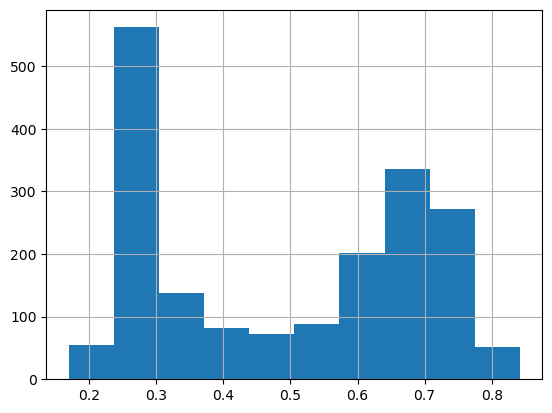

In [1247]:
# Распределение скоров
pd.Series(predict_proba[:,1]).hist()

#### Тест для вашей имплементации. Если класс написан правильно, две следующие ячейки должна отработать без ошибок и относительно быстро (у автора задания 2 и 0.2 секунд соответственно, accuracy 0.911 и 0.879 соответственно). Если у вас получилось качество выше указанного — отлично!

In [1014]:
%%time

boosting = Boosting(learning_rate=0.5)
boosting.fit(X_train_synthetic, y_train_synthetic)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(X_test_synthetic) > 0.5)
print('accuracy_score: ', accuracy_score((y_test_synthetic == 1), np.round(preds)))
score = accuracy_score((y_test_synthetic == 1), np.round(preds))
assert accuracy_score((y_test_synthetic == 1), np.round(preds)) > 0.9

Model fitted
accuracy_score:  0.9142
CPU times: user 670 ms, sys: 10.2 ms, total: 680 ms
Wall time: 683 ms


In [1010]:
%%time

boosting = Boosting(learning_rate=0.7)
boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
print(accuracy_score((df_test.y.values == 1), np.round(preds)))
assert accuracy_score((df_test.y.values == 1), np.round(preds)) > 0.87

Model fitted
0.8717672413793104
CPU times: user 79.2 ms, sys: 5.77 ms, total: 85 ms
Wall time: 94 ms


__________________________________________________________________________________________

#### 2. (2 балла) Сравните результаты вашей имплементации бустинга с указанными ниже базовыми моделями на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных. 

Варианты для базовой модели (разумеется, не надо их программировать самостоятельно, берите нужные классы из sklearn):

- Решающее дерево глубины 6
- Случайный лес (число деревьев — на ваше усмотрение, только не слишком мало)
- Линейная регрессия

Вопросы:

1) Какая из моделей имеет оптимальное качество? С чем это связано?

2) Какая из моделей сильнее переобучается? Есть ли преимущества от использования ранней остановки и обрезания бустинга до лучшей модели?

3) Работает ли бустинг над линейными регрессиями лучше, чем одна логистическая регрессия? Как объяснить этот результат?

4) Визуализируйте предсказания моделей на синтетическом датасете (для этого можете воспользоваться вспомогательной функцией plot_predicts). Чем отличаются картинки, которые получаются у разных алгоритмов? Сделайте выводы.

___Bank data___

In [924]:
boosting = Boosting(learning_rate=0.7)
tree = DecisionTreeClassifier(max_depth=6)
RF = RandomForestClassifier(n_estimators=99)
lr = LogisticRegression()

In [969]:
boosting.fit(X_train, y_train)

y_pred_train = boosting.predict(X_train)
roc_metric = roc_auc_score(y_train, y_pred_train)
print(f'TRAIN DATA - ROC AUC BOOSTING: {roc_metric}')

y_pred = boosting.predict(X_test)
roc_metric = roc_auc_score(y_test, y_pred)
print(f'ROC AUC BOOSTING: {roc_metric}')

preds = np.round(y_pred > 0.5)
print('accuracy_score:', accuracy_score((y_test.values == 1), np.round(preds)))



Model fitted
TRAIN DATA - ROC AUC BOOSTING: 0.8917685444934007
ROC AUC BOOSTING: 0.8827425195349724
accuracy_score: 0.8820043103448276


In [970]:
tree.fit(X_train, y_train)

y_pred_train = tree.predict(X_train)
roc_metric = roc_auc_score(y_train, y_pred_train)
print(f'TRAIN DATA - ROC AUC DECISION TREE: {roc_metric}')

y_pred = tree.predict(X_test)
roc_metric = roc_auc_score(y_test, y_pred)
print(f'ROC AUC DECISION TREE: {roc_metric}')

preds = np.round(y_pred > 0.5)
print('accuracy_score:', accuracy_score((y_test.values == 1), np.round(preds)))


TRAIN DATA - ROC AUC DECISION TREE: 0.8916593145089063
ROC AUC DECISION TREE: 0.8820975516787759
accuracy_score: 0.8814655172413793


In [971]:
RF.fit(X_train, y_train)

y_pred_train = RF.predict(X_train)
roc_metric = roc_auc_score(y_train, y_pred_train)
print(f'TRAIN DATA - ROC AUC RF: {roc_metric}')

y_pred = RF.predict(X_test)
roc_metric = roc_auc_score(y_test, y_pred)
print(f'ROC AUC RF: {roc_metric}')

preds = np.round(y_pred > 0.5)
print('accuracy_score:', accuracy_score((y_test.values == 1), np.round(preds)))

TRAIN DATA - ROC AUC RF: 1.0
ROC AUC RF: 0.8847076378139425
accuracy_score: 0.8836206896551724


In [972]:
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
roc_metric = roc_auc_score(y_train, y_pred_train)
print(f'TRAIN DATA - ROC AUC LR: {roc_metric}')

y_pred = lr.predict(X_test)
roc_metric = roc_auc_score(y_test, y_pred)
print(f'ROC AUC LR: {roc_metric}')

preds = np.round(y_pred > 0.5)
print('accuracy_score:', accuracy_score((y_test.values == 1), np.round(preds)))

TRAIN DATA - ROC AUC LR: 0.8563517562584788
ROC AUC LR: 0.8527079353126292
accuracy_score: 0.8523706896551724


/Users/dan/miniconda3/envs/mlops_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [1023]:
# Extra: BOOSTING on Linear Model

boosting_lr = Boosting(base_model_class=LinearRegression, base_model_params={'n_jobs':-1})
boosting_lr.fit(X_train, y_train)

y_pred_train = boosting_lr.predict(X_train)
roc_metric = roc_auc_score(y_train, y_pred_train)
print(f'TRAIN DATA - ROC AUC BOOSTING: {roc_metric}')

y_pred = boosting_lr.predict(X_test)
roc_metric = roc_auc_score(y_test, y_pred)
print(f'ROC AUC BOOSTING: {roc_metric}')

preds = np.round(y_pred > 0.5)
print('accuracy_score:', accuracy_score((y_test.values == 1), np.round(preds)))

Model fitted
TRAIN DATA - ROC AUC BOOSTING: 0.741809928504802
ROC AUC BOOSTING: 0.7436293445267216
accuracy_score: 0.7494612068965517


1) Какая из моделей имеет оптимальное качество? С чем это связано?

Все деревянные модели показали качество на уровне ROC AUC = 0.88, accuracy_score так же равен 0.88
Я думаю это объяснимо тем, что данные достаточно просто разделимы обычным деревом глубиной 6



2) Какая из моделей сильнее переобучается? Есть ли преимущества от использования ранней остановки и обрезания бустинга до лучшей модели?

В связи с тем, что нам хватает простого разделения дерева глубиной 6 - я бы предпложожил, что рандомный лес или градиентный бустинг могут переобучаться. Но градиентный бустинг на тренировочных данных так же ошибается, как и на тестовх - это значит, что он не так подстроился под тренировочный датасет, что бы сказать что модель переобучена. А рандомный лес? в свою очередь, очень сильно запомнил обучающую выборку и на ней дает ROC AUC = 1, что является сингалом переобучения


3) Работает ли бустинг над линейными регрессиями лучше, чем одна логистическая регрессия? Как объяснить этот результат?

Бустинг над линейными моделями не эффективен - в бустинге мы минимизируем смещение при помощь построение новых моделей. Линейная же модель, как ее не строй - не будет вносить новый вклад, так как будет проходить почти по той же линии, как и прошлые базовые алгоритмы. Тем самым мы не снизим смещение, а это основная идея бустинга. БУстинг над линейной моделью оказался хуже, чем простая линейная модель - возможно это связанно с переобучением - мы как не могли тренировочные данные безупречно разделить так и не можем, но сейчас бустинг изменил смещение итоговой модели в сравнении с "идеальным построением" (которое рассчитыввается при обучении лог регрессии) одной модели - это привело к увеличению ошибки

___Syntetic data___

In [974]:
boosting.fit(X_train_synthetic, y_train_synthetic)

y_pred_train = boosting.predict(X_train_synthetic)
roc_metric = roc_auc_score(y_train_synthetic, y_pred_train)
print(f'TRAIN DATA - ROC AUC BOOSTING: {roc_metric}')

y_pred = boosting.predict(X_test_synthetic)
roc_metric = roc_auc_score(y_test_synthetic, y_pred)
print(f'ROC AUC BOOSTING: {roc_metric}')

preds = np.round(y_pred > 0.5)
print('accuracy_score:', accuracy_score((y_test_synthetic == 1), np.round(preds)))

Model fitted
TRAIN DATA - ROC AUC BOOSTING: 0.9189970211728092
ROC AUC BOOSTING: 0.9164171767114035
accuracy_score: 0.9165


In [975]:
tree.fit(X_train_synthetic, y_train_synthetic)

y_pred_train = tree.predict(X_train_synthetic)
roc_metric = roc_auc_score(y_train_synthetic, y_pred_train)
print(f'TRAIN DATA - ROC AUC DECISION TREE: {roc_metric}')

y_pred = tree.predict(X_test_synthetic)
roc_metric = roc_auc_score(y_test_synthetic, y_pred)
print(f'ROC AUC DECISION TREE: {roc_metric}')

preds = np.round(y_pred > 0.5)
print('accuracy_score:', accuracy_score((y_test_synthetic == 1), np.round(preds)))

TRAIN DATA - ROC AUC DECISION TREE: 0.9037145303274501
ROC AUC DECISION TREE: 0.9020458301357861
accuracy_score: 0.90255


In [976]:
RF.fit(X_train_synthetic, y_train_synthetic)

y_pred_train = RF.predict(X_train_synthetic)
roc_metric = roc_auc_score(y_train_synthetic, y_pred_train)
print(f'TRAIN DATA - ROC AUC RF: {roc_metric}')

y_pred = RF.predict(X_test_synthetic)
roc_metric = roc_auc_score(y_test_synthetic, y_pred)
print(f'ROC AUC RF: {roc_metric}')

preds = np.round(y_pred > 0.5)
print('accuracy_score:', accuracy_score((y_test_synthetic == 1), np.round(preds)))

TRAIN DATA - ROC AUC RF: 0.9999749999868593
ROC AUC RF: 0.9116190679090279
accuracy_score: 0.9117


In [977]:
lr.fit(X_train_synthetic, y_train_synthetic)

y_pred_train = lr.predict(X_train_synthetic)
roc_metric = roc_auc_score(y_train_synthetic, y_pred_train)
print(f'TRAIN DATA - ROC AUC LR: {roc_metric}')

y_pred = lr.predict(X_test_synthetic)
roc_metric = roc_auc_score(y_test_synthetic, y_pred)
print(f'ROC AUC LR: {roc_metric}')

preds = np.round(y_pred > 0.5)
print('accuracy_score:', accuracy_score((y_test_synthetic == 1), np.round(preds)))

TRAIN DATA - ROC AUC LR: 0.6925872931036959
ROC AUC LR: 0.6890854052064447
accuracy_score: 0.68905


In [1025]:
# Extra1: BOOSTING on Linear Model

boosting_lr = Boosting(base_model_class=LinearRegression, base_model_params={'n_jobs':-1})
boosting_lr.fit(X_train_synthetic, y_train_synthetic)

y_pred_train = boosting_lr.predict(X_train_synthetic)
roc_metric = roc_auc_score(y_train_synthetic, y_pred_train)
print(f'TRAIN DATA - ROC AUC BOOSTING: {roc_metric}')

y_pred = boosting_lr.predict(X_test_synthetic)
roc_metric = roc_auc_score(y_test_synthetic, y_pred)
print(f'ROC AUC BOOSTING: {roc_metric}')

preds = np.round(y_pred > 0.5)
print('accuracy_score:', accuracy_score((y_test_synthetic == 1), np.round(preds)))

Model fitted
TRAIN DATA - ROC AUC BOOSTING: 0.6110253861702186
ROC AUC BOOSTING: 0.6114123994569858
accuracy_score: 0.6059


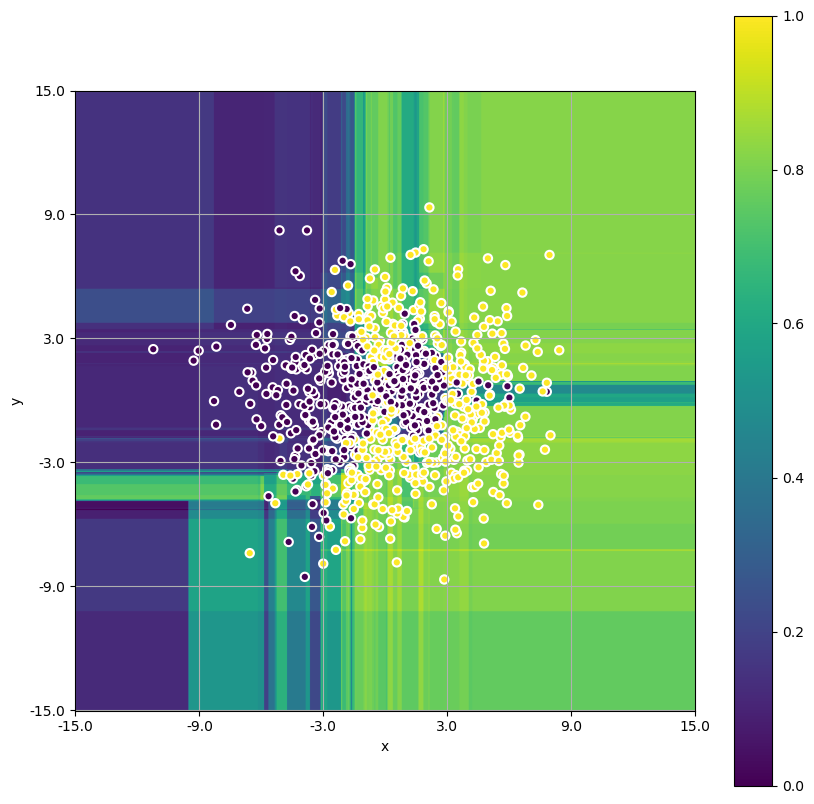

In [978]:
# Boosting
plot_predicts(boosting, X_train_synthetic, y_train_synthetic, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0])

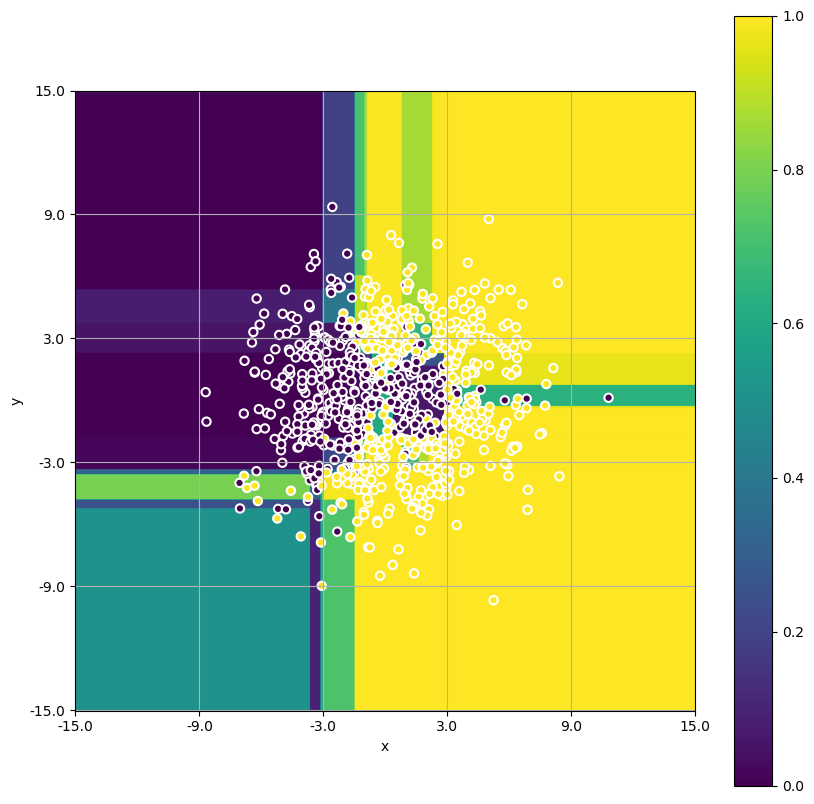

In [979]:
# Tree
plot_predicts(tree, X_train_synthetic, y_train_synthetic, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0])

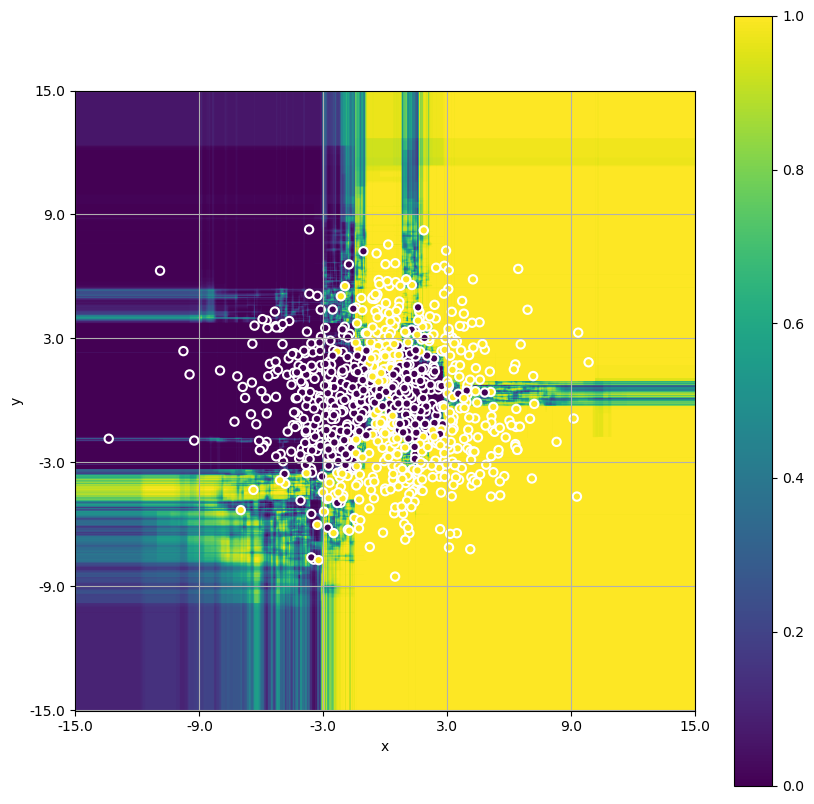

In [980]:
# Random forest
plot_predicts(RF, X_train_synthetic, y_train_synthetic, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0])

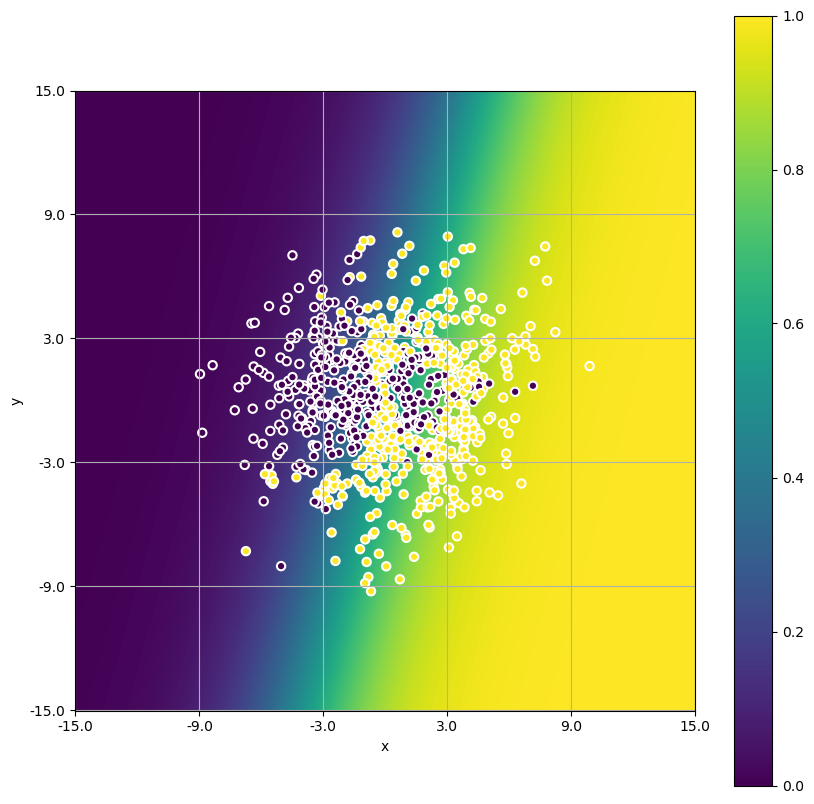

In [981]:
# Logistic regressor
plot_predicts(lr, X_train_synthetic, y_train_synthetic, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0])

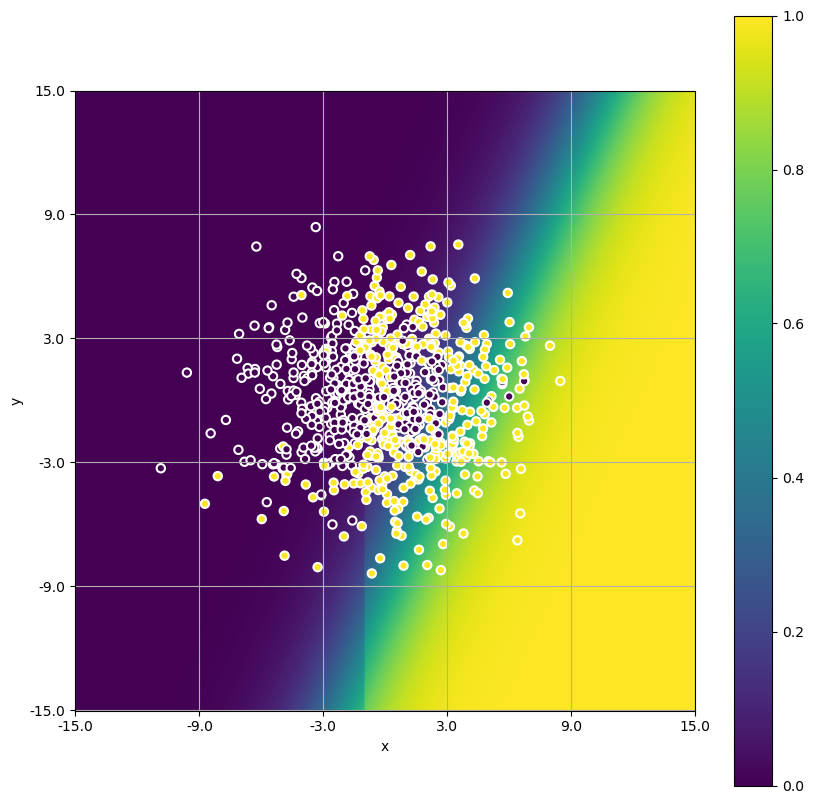

In [1026]:
# Boosting on Linear Model
plot_predicts(boosting_lr, X_train_synthetic, y_train_synthetic, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0])

Вопросы:

1) Какая из моделей имеет оптимальное качество? С чем это связано?

Здесь неглубокое дерево уже проигрывает более сложным алгоритмам в виде случайного леса и градиентного бусинга, скорее всего по причине того, что нет возможности с глубиной 6 так же хорошо разделить плоскость (или в целом одного дерева недостаточно). Я должен заметить, что мой алгоритм не такой стабильный и имеет больший разброс при нескольких итерациях обучения? в отличии от модели из sclearn которые практически те же метрики дают после новой итераци обучения, но все ровно заметно превосходство бустинга над деревом.

Линейная модель выглядит очень слабо ввиду того, что нет возможности разделить признаки гиперплоскостью с качеством, как это можно сделать несколькими "плоскостями" в случае деревьев. 

2) Какая из моделей сильнее переобучается? Есть ли преимущества от использования ранней остановки и обрезания бустинга до лучшей модели?

Тут ровно та же ситуция, как и на банковских данных - случайный лес сильно переобучился и почти идеально предсказывает тренировчные данные, а на тесте метрики падают, но не настолько, что бы считать алгоритм посредственным.


3) Работает ли бустинг над линейными регрессиями лучше, чем одна логистическая регрессия? Как объяснить этот результат?

Предположение которое я сделал в пункте 3 про банковские данные оказалось верным - действительно разделяющая плоскость сместилась и стала еще зуже обощать данные - ошибка выросла, метрики упали

4) Визуализируйте предсказания моделей на синтетическом датасете (для этого можете воспользоваться вспомогательной функцией plot_predicts). Чем отличаются картинки, которые получаются у разных алгоритмов? Сделайте выводы.

Можно заметить, что градиентный бустинг и рандомный лес очень сильно пытаюстя разделить пространство множеством линий. ПРиемуществом рандомного леса я бы выделил в более уверенной классификации правильных ответов - много объектов попадает в области большой уверенности (0 - 0.1 и 0.9 - 1), то есть алгоритм уверенее разделяет классы.

Дерево решений не сложно, но достаточно качественно разделило плоскость (гиперплоскость, есл иточнее) и так же уверена в ответах в "очевидных" случаях (основываясь на график)

Линейная модель не смогла выделить центральную часть (объекты класса 0), проведя раздлеяющую плоскость прям по ним, а так же и по объектам 1 класса - совершив много ошибок. Линейная модель в целом не способна выделять подобынй центр, правда если создать полиномиальыне признаки (квадраты, кубы) - ситуация может измениться

__________________________________________________________________________________________

#### 3. (2 балла) Мы разобрались с бустингом, теперь интересно посмотреть на совсем дикие комбинации моделей. Сравните результаты следующих моделей на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных.

Используйте логистическую регрессию, случайный лес и BaggingClassifier из sklearn.

- Случайный лес
- Бэггинг на деревьях (поставьте для базовых деревьев min_samples_leaf=1)
- Бэггинг на деревьях с обучением каждого дерева на подмножестве признаков (`max_features` около 0.6 в BaggingClassifier)
- Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)
- Бэггинг на логистических регрессиях

1) Какая из моделей имеет лучшее качество? С чем это связано?

2) Какая из моделей сильнее всего переобучается? Помогает ли бустингу ранняя остановка? 

3) Исправляет ли бэггинг переобученность бустинга с большим числом деревьев?

4) Что лучше: случайный лес или бэггинг на деревьях с сэмплированием признаков?

5) Если использовать деревья в качестве базового алгоритма, что лучше — бэггинг или бустинг? С чем это связано?

In [1171]:
def print_result_bank( 
        ml_name:str,
        y_pred_test:np.array, 
        y_pred_train:np.array,
        y_test:np.array = y_test, 
        y_train:np.array = y_train
        ):
    '''Функция для подсчета метрик на train (как сигнал о переобучении) и test (способность к обобщению)'''

    preds = np.round(y_pred_train > 0.5)
    print(f'{ml_name} TRAIN DATA: accuracy_score:', accuracy_score((y_train == 1), np.round(preds)))

    preds = np.round(y_pred_test > 0.5)
    print(f'{ml_name} TEST DATA: accuracy_score:', accuracy_score((y_test == 1), np.round(preds)))

    print('_____________________________________')
    

In [1170]:
def print_result_syntetic( 
        ml_name:str,
        y_pred_test:np.array, 
        y_pred_train:np.array,
        y_test:np.array = y_test_synthetic, 
        y_train:np.array = y_train_synthetic
        ):
    '''Функция для подсчета метрик на train (как сигнал о переобучении) и test (способность к обобщению)'''

    preds = np.round(y_pred_train > 0.5)
    print(f'{ml_name} TRAIN DATA: accuracy_score:', accuracy_score((y_train == 1), np.round(preds)))

    preds = np.round(y_pred_test > 0.5)
    print(f'{ml_name} TEST DATA: accuracy_score:', accuracy_score((y_test == 1), np.round(preds)))

    print('_____________________________________')

___Bank data___

In [1175]:
# 1. Random forest
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

preds_rf = RF.predict_proba(X_test)[:,1]
preds_rf_train = RF.predict_proba(X_train)[:,1]

In [1176]:
# 2. BaggingClassifier - min_samples_leaf=1

bagging_msl = BaggingClassifier(estimator=DecisionTreeClassifier(min_samples_leaf=1), random_state=42)
bagging_msl.fit(X_train, y_train)

preds_bag_msl = bagging_msl.predict_proba(X_test)[:,1]
preds_bag_msl_train = bagging_msl.predict_proba(X_train)[:,1]

In [1177]:
# 3. BaggingClassifier - max_features=0.6

bagging_mf = BaggingClassifier(estimator=DecisionTreeClassifier(), max_features=0.6, random_state=42)
bagging_mf.fit(X_train, y_train)

preds_bag_mf = bagging_mf.predict_proba(X_test)[:,1]
preds_bag_mf_train = bagging_mf.predict_proba(X_train)[:,1]


In [1178]:
# 4. BaggingClassifier - boosting

#bagging_boosting = BaggingClassifier(estimator=Boosting(n_estimators=200), max_features=0.6, random_state=42)
#bagging_boosting.fit(X_train, y_train)
#TypeError: Cannot clone object '<__main__.Boosting object at 0x18e9a5fd0>' (type <class '__main__.Boosting'>): 
# it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

# => Насколько я понял из чата - допустимо взять GradientBoostingClassifier, который был импортирован сразу в ноутбук (в заготовке)

bagging_boosting = BaggingClassifier(estimator=GradientBoostingClassifier(n_estimators=200), max_features=0.6, random_state=42)
bagging_boosting.fit(X_train, y_train)

preds_bag_boosting = bagging_boosting.predict_proba(X_test)[:,1]
preds_bag_boosting_train = bagging_boosting.predict_proba(X_train)[:,1]

In [1179]:
# 5. BaggingClassifier - LogReg

bagging_lr = BaggingClassifier(estimator=LogisticRegression(), random_state=42)
bagging_lr.fit(X_train, y_train)

preds_bag_lr = bagging_lr.predict_proba(X_test)[:,1]
preds_bag_lr_train = bagging_lr.predict_proba(X_train)[:,1]

/Users/dan/miniconda3/envs/mlops_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/dan/miniconda3/envs/mlops_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

In [1180]:
# EXTRA. BaggingClassifier - boosting early_stop

bagging_boosting_early_stop = BaggingClassifier(estimator=GradientBoostingClassifier(
                                                    n_estimators=200, 
                                                    validation_fraction=0.1, 
                                                    n_iter_no_change=10)
                                                    , max_features=0.6, random_state=42
                                    )
bagging_boosting_early_stop.fit(X_train, y_train)

preds_bag_boosting_es = bagging_boosting_early_stop.predict_proba(X_test)[:,1]
preds_bag_boosting_es_train = bagging_boosting_early_stop.predict_proba(X_train)[:,1]

In [1182]:
# My Boosting
boosting = Boosting(learning_rate=.7)

boosting.fit(X_train, y_train)

preds_boosting = boosting.predict_proba(X_test)[:,1]
preds_boosting_train = boosting.predict_proba(X_train)[:,1]

Model fitted


In [1192]:
# My Boosting early_stop
boosting_es = Boosting(learning_rate=.7, n_iter_early_stopping=30)

boosting_es.fit(X_train, y_train)

preds_boosting_es = boosting_es.predict_proba(X_test)[:,1]
preds_boosting_es_train = boosting_es.predict_proba(X_train)[:,1]

Model fitted


In [1194]:
print_result_bank('RandomForestClassifier', preds_rf, preds_rf_train)
print_result_bank('BaggingClassifier + Tree + Min Sample Leafs', preds_bag_msl, preds_bag_msl_train)
print_result_bank('BaggingClassifier + Tree + Max Features', preds_bag_mf, preds_bag_mf_train)
print_result_bank('BaggingClassifier + Boosting', preds_bag_boosting, preds_bag_boosting_train)
print_result_bank('BaggingClassifier + Boosting + Early stop', preds_bag_boosting_es, preds_bag_boosting_es_train)
print_result_bank('BaggingClassifier + LogReg', preds_bag_lr, preds_bag_lr_train)
print_result_bank('My boosting', preds_boosting, preds_boosting_train)
print_result_bank('My boosting + Early stop', preds_boosting_es, preds_boosting_es_train)

RandomForestClassifier TRAIN DATA: accuracy_score: 1.0
RandomForestClassifier TEST DATA: accuracy_score: 0.880926724137931
_____________________________________
BaggingClassifier + Tree + Min Sample Leafs TRAIN DATA: accuracy_score: 0.9925915948275862
BaggingClassifier + Tree + Min Sample Leafs TEST DATA: accuracy_score: 0.8760775862068966
_____________________________________
BaggingClassifier + Tree + Max Features TRAIN DATA: accuracy_score: 0.9938038793103449
BaggingClassifier + Tree + Max Features TEST DATA: accuracy_score: 0.8674568965517241
_____________________________________
BaggingClassifier + Boosting TRAIN DATA: accuracy_score: 0.9034213362068966
BaggingClassifier + Boosting TEST DATA: accuracy_score: 0.8879310344827587
_____________________________________
BaggingClassifier + Boosting + Early stop TRAIN DATA: accuracy_score: 0.8954741379310345
BaggingClassifier + Boosting + Early stop TEST DATA: accuracy_score: 0.8900862068965517
_____________________________________
Baggi

1) Какая из моделей имеет лучшее качество? С чем это связано?

Бустинг имеет лучшее качество. С чем связанно - наверное алгоритм исправления смещения лучше, чем алгоритм усреднения разброса для этих данных.

2) Какая из моделей сильнее всего переобучается? Помогает ли бустингу ранняя остановка? 

Модели построенные на основе деревьев: RF, BaggingClassifier с Min Sample Leafs и Max Features.
В них нет ограничение на глубину деревьев, что позволяет очень хорошо запомнить выборку. Скорее всего если аккуратно гораничит деревья, например в RF то качество на трейне упадет, на тесте подростет. Я использовал early stopping для GradientBoostingClassifier. Метрика на трейне действительно упала, на тесте - выросла.  
Техника early stopping позволяет не "убежать" из минимума функции потерь, а остаться там.

3) Исправляет ли бэггинг переобученность бустинга с большим числом деревьев?

Да, бэггинг действительно помогает уменьшить переобучение. Основная причина этому - создание множества обучающих подвыборок при помощи бутстрепа. Затем переобучение так же убирается путем голосования всех алгоритмов (обученных бустингов)

4) Что лучше: случайный лес или бэггинг на деревьях с сэмплированием признаков?

В моем случае случайные лес оказался лучше, чем бэггинг на деревьях с сэмплированием признаков 0.883 VS 0.867

5) Если использовать деревья в качестве базового алгоритма, что лучше — бэггинг или бустинг? С чем это связано?

* BaggingClassifier + Boosting -> 0.888 , 0.89
* BaggingClassifier + Tree -> 0.867 , 0.876
* My boosting + Early stop -> 0.88


Бэггинг над деревиями оказался менее эффективным алгоритмом, по сравнению с моим бустингом (в частности с подкрученным на early stop). 

В обоих случаях (бэггинг для деревьев, бустинг на пеньках)  для обучение каждой базовой модели используется бустрапированная подвыборка. Алгоритм минимизации смещения (путем минимизации новыми базовыми алгоритмами работает лучше, чем построение переобученных деревьев с последующим голосованием). Предположу, что десяток переобученных моделей имеют слишком большой разброс, что усреднение их ответов не так эффективно, как смещение кучного прогноза базовых алгоритмов в сторону минимизации смещения

(Более сложный базовый алгоритм (бустинг) позволяет модели бэггинга показывать самые лучшие результаты.)



___Syntetic data___

In [1198]:
# 1. Random forest
RF = RandomForestClassifier()
RF.fit(X_train_synthetic, y_train_synthetic)

preds_rf = RF.predict_proba(X_test_synthetic)[:,1]
preds_rf_train = RF.predict_proba(X_train_synthetic)[:,1]

In [1199]:
# 2. BaggingClassifier - min_samples_leaf=1

bagging_msl = BaggingClassifier(estimator=DecisionTreeClassifier(min_samples_leaf=1), random_state=42)
bagging_msl.fit(X_train_synthetic, y_train_synthetic)

preds_bag_msl = bagging_msl.predict_proba(X_test_synthetic)[:,1]
preds_bag_msl_train = bagging_msl.predict_proba(X_train_synthetic)[:,1]

In [1200]:
# 3. BaggingClassifier - max_features=0.6

bagging_mf = BaggingClassifier(estimator=DecisionTreeClassifier(), max_features=0.6, random_state=42)
bagging_mf.fit(X_train_synthetic, y_train_synthetic)

preds_bag_mf = bagging_mf.predict_proba(X_test_synthetic)[:,1]
preds_bag_mf_train = bagging_mf.predict_proba(X_train_synthetic)[:,1]

In [1201]:
# 4. BaggingClassifier - boosting

#bagging_boosting = BaggingClassifier(estimator=Boosting(n_estimators=200), max_features=0.6, random_state=42)
#bagging_boosting.fit(X_train, y_train)
#TypeError: Cannot clone object '<__main__.Boosting object at 0x18e9a5fd0>' (type <class '__main__.Boosting'>): 
# it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

# => Насколько я понял из чата - допустимо взять GradientBoostingClassifier, который был импортирован сразу в ноутбук (в заготовке)

bagging_boosting = BaggingClassifier(estimator=GradientBoostingClassifier(n_estimators=200), max_features=0.6, random_state=42)
bagging_boosting.fit(X_train_synthetic, y_train_synthetic)

preds_bag_boosting = bagging_boosting.predict_proba(X_test_synthetic)[:,1]
preds_bag_boosting_train = bagging_boosting.predict_proba(X_train_synthetic)[:,1]

In [1202]:
# 5. BaggingClassifier - LogReg

bagging_lr = BaggingClassifier(estimator=LogisticRegression(), random_state=42)
bagging_lr.fit(X_train_synthetic, y_train_synthetic)

preds_bag_lr = bagging_lr.predict_proba(X_test_synthetic)[:,1]
preds_bag_lr_train = bagging_lr.predict_proba(X_train_synthetic)[:,1]

In [1203]:
# EXTRA. BaggingClassifier - boosting early_stop

bagging_boosting_early_stop = BaggingClassifier(estimator=GradientBoostingClassifier(
                                                    n_estimators=200, 
                                                    validation_fraction=0.1, 
                                                    n_iter_no_change=10)
                                                    , max_features=0.6, random_state=42
                                    )
bagging_boosting_early_stop.fit(X_train_synthetic, y_train_synthetic)

preds_bag_boosting_es = bagging_boosting_early_stop.predict_proba(X_test_synthetic)[:,1]
preds_bag_boosting_es_train = bagging_boosting_early_stop.predict_proba(X_train_synthetic)[:,1]

In [1204]:
# My Boosting
boosting = Boosting(learning_rate=.7)

boosting.fit(X_train_synthetic, y_train_synthetic)

preds_boosting = boosting.predict_proba(X_test_synthetic)[:,1]
preds_boosting_train = boosting.predict_proba(X_train_synthetic)[:,1]

Model fitted


In [1211]:
# My Boosting early_stop
boosting_es = Boosting(learning_rate=.7, n_iter_early_stopping=50)

boosting_es.fit(X_train_synthetic, y_train_synthetic)

preds_boosting_es = boosting_es.predict_proba(X_test_synthetic)[:,1]
preds_boosting_es_train = boosting_es.predict_proba(X_train_synthetic)[:,1]

Model fitted


In [1212]:
print_result_syntetic('RandomForestClassifier', preds_rf, preds_rf_train)
print_result_syntetic('BaggingClassifier + Tree + Min Sample Leafs', preds_bag_msl, preds_bag_msl_train)
print_result_syntetic('BaggingClassifier + Tree + Max Features', preds_bag_mf, preds_bag_mf_train)
print_result_syntetic('BaggingClassifier + Boosting', preds_bag_boosting, preds_bag_boosting_train)
print_result_syntetic('BaggingClassifier + Boosting + Early stop', preds_bag_boosting_es, preds_bag_boosting_es_train)
print_result_syntetic('BaggingClassifier + LogReg', preds_bag_lr, preds_bag_lr_train)
print_result_syntetic('My boosting', preds_boosting, preds_boosting_train)
print_result_syntetic('My boosting + Early stop', preds_boosting_es, preds_boosting_es_train)

RandomForestClassifier TRAIN DATA: accuracy_score: 0.9999875
RandomForestClassifier TEST DATA: accuracy_score: 0.9116
_____________________________________
BaggingClassifier + Tree + Min Sample Leafs TRAIN DATA: accuracy_score: 0.99275
BaggingClassifier + Tree + Min Sample Leafs TEST DATA: accuracy_score: 0.90265
_____________________________________
BaggingClassifier + Tree + Max Features TRAIN DATA: accuracy_score: 0.9836
BaggingClassifier + Tree + Max Features TEST DATA: accuracy_score: 0.6795
_____________________________________
BaggingClassifier + Boosting TRAIN DATA: accuracy_score: 0.838725
BaggingClassifier + Boosting TEST DATA: accuracy_score: 0.8362
_____________________________________
BaggingClassifier + Boosting + Early stop TRAIN DATA: accuracy_score: 0.8362875
BaggingClassifier + Boosting + Early stop TEST DATA: accuracy_score: 0.83655
_____________________________________
BaggingClassifier + LogReg TRAIN DATA: accuracy_score: 0.6926375
BaggingClassifier + LogReg TEST D

1) Какая из моделей имеет лучшее качество? С чем это связано?

RandomForestClassifier c 200 деревьями оказался лучшим алгоритмом. Усреднять разброс на таких данных оказалось лучше, чем работать над смещением (в град. бустинге).

2) Какая из моделей сильнее всего переобучается? Помогает ли бустингу ранняя остановка? 

Снова переобучились модели построенные на основе деревьев: RF, BaggingClassifier с Min Sample Leafs и Max Features.
Отмечу, что переобучение больше всего повлияло на BaggingClassifier + Tree + Max Features, где дерево обучалось на 1 фиче - видимо на тренировочных данных ей удалось найти оптимальынй алгоритм для предсказания, который провалился на тесте

3) Исправляет ли бэггинг переобученность бустинга с большим числом деревьев?

В данном примере Early stop не сырал никакой роли - видимо градиент функции потерь не "выпрыгнул" из глобального минимума. 

4) Что лучше: случайный лес или бэггинг на деревьях с сэмплированием признаков?

бэггинг на деревьях с сэмплированием признаков провалился, метрика Accuracy в сравнении с случайным лесом 0.6795 VS 0.867

5) Если использовать деревья в качестве базового алгоритма, что лучше — бэггинг или бустинг? С чем это связано?

Бустинг в целом победил все остальные алгоритмы. Почему - описывал в пункте 5 про банковские данные? мысли такие же

__________________________________________________________________________________________

#### 4. (2 балла) Сравните на этих данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost) с вашей реализацией. Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев) для обоих методов. Получилось ли у вас победить библиотечные реализации на тестовых данных? 

___Для задания возьму банковские данные___

In [1115]:
X_train.head()

age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   28       637         1    999         0           1.4          93.918   
1   44       895         1    999         0          -1.8          93.075   
2   54       253         3    999         0           1.1          93.994   
3   37       633         1    999         0           1.4          93.918   
4   30       648         1    999         0          -1.8          93.075   

   cons.conf.idx  euribor3m  nr.employed  job_admin.  job_blue-collar  \
0          -42.7      4.958       5228.1         0.0              1.0   
1          -47.1      1.453       5099.1         0.0              0.0   
2          -36.4      4.860       5191.0         0.0              1.0   
3          -42.7      4.963       5228.1         0.0              0.0   
4          -47.1      1.410       5099.1         1.0              0.0   

   job_entrepreneur  job_housemaid  job_management  job_retired  \
0               0.0            0.0             0.0          0.0   
1               0.0            0.0             0.0          0.0   
2               0.0            0.0             0.0          0.0   
3               0.0            0.0             0.0          0.0   
4               0.0            0.0             0.0          0.0   

   job_self-employed  job_services  job_student  job_technician  \
0                0.0           0.0          0.0             0.0   
1                0.0           1.0          0.0             0.0   
2                0.0           0.0          0.0             0.0   
3                0.0           0.0          0.0             0.0   
4                0.0           0.0          0.0             0.0   

   job_unemployed  job_unknown  marital_divorced  marital_married  \
0             0.0          0.0               0.0              0.0   
1             0.0          0.0               1.0              0.0   
2             0.0          0.0               0.0              0.0   
3             1.0          0.0               0.0              0.0   
4             0.0          0.0               0.0              1.0   

   marital_single  marital_unknown  education_basic.4y  education_basic.6y  \
0             1.0              0.0                 0.0                 0.0   
1             0.0              0.0                 0.0                 0.0   
2             1.0              0.0                 1.0                 0.0   
3             1.0              0.0                 0.0                 0.0   
4             0.0              0.0                 0.0                 0.0   

   education_basic.9y  education_high.school  education_illiterate  \
0                 0.0                    0.0                   0.0   
1                 0.0                    1.0                   0.0   
2                 0.0                    0.0                   0.0   
3                 1.0                    0.0                   0.0   
4                 0.0                    1.0                   0.0   

   education_professional.course  education_university.degree  \
0                            0.0                          0.0   
1                            0.0                          0.0   
2                            0.0                          0.0   
3                            0.0                          0.0   
4                            0.0                          0.0   

   education_unknown  default_no  default_unknown  housing_no  \
0                1.0         1.0              0.0         1.0   
1                0.0         1.0              0.0         0.0   
2                0.0         1.0              0.0         1.0   
3                0.0         0.0              1.0         0.0   
4                0.0         0.0              1.0         0.0   

   housing_unknown  housing_yes  loan_no  loan_unknown  loan_yes  \
0              0.0          0.0      1.0           0.0       0.0   
1              0.0          1.0      0.0           0.0       1.0   
2   

In [1098]:
boosting = Boosting(learning_rate=0.7)
cb_base = CatBoostClassifier()

In [1096]:
# Обучение, метрики на трейне (смотрим на переобучение) и тест для ручного бустинга 

boosting.fit(X_train, y_train)

y_pred_train = boosting.predict(X_train)
roc_metric = roc_auc_score(y_train, y_pred_train)
print(f'TRAIN DATA - ROC AUC BOOSTING: {roc_metric}')

y_pred = boosting.predict(X_test)
roc_metric = roc_auc_score(y_test, y_pred)
print(f'ROC AUC BOOSTING: {roc_metric}')

preds = np.round(y_pred > 0.5)
print('accuracy_score:', accuracy_score((y_test.values == 1), np.round(preds)))

Model fitted
TRAIN DATA - ROC AUC BOOSTING: 0.8876240467960125
ROC AUC BOOSTING: 0.8761917379036569
accuracy_score: 0.8760775862068966


In [1100]:
# Обучение, метрики на трейне (смотрим на переобучение) и тест для ручного бустинга 

cb_base.fit(X_train, y_train, verbose=False)

y_pred_train = cb_base.predict(X_train)
roc_metric = roc_auc_score(y_train, y_pred_train)
print(f'TRAIN DATA - ROC AUC CB: {roc_metric}')

y_pred = cb_base.predict(X_test)
roc_metric = roc_auc_score(y_test, y_pred)
print(f'ROC AUC CB: {roc_metric}')

preds = np.round(y_pred > 0.5)
print('accuracy_score:', accuracy_score((y_test.values == 1), np.round(preds)))

TRAIN DATA - ROC AUC CB: 0.9345933755969907
ROC AUC CB: 0.9007934847787586
accuracy_score: 0.8997844827586207


Кэтбуст из коробки значительно превосходит рукописный бустинг, попробую подобрать гиперпараметры так, что бы побить результат Cat Boost из коробки

In [ ]:
boosting_cv = Boosting()

learning_rate_list = [.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
n_estimators_list = [2, 5, 10]
max_depth_list = [None, 2, 3, 4, 5, 6, 8, 10]
min_samples_leaf_list = [1, 2, 5]

score_dict = dict()

#grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# В цикле проходимся по декартову произведению гиперпараметров
for lr in tqdm(learning_rate_list):
    for n_esm in n_estimators_list:
        for max_dpth in max_depth_list:
            for min_sl in min_samples_leaf_list:

                # Обучаем очередной рукописный бустинг
                boosting = Boosting(
                    learning_rate=lr, 
                    n_estimators=n_esm, 
                    base_model_params={'max_depth': max_dpth,
                                       'min_samples_leaf':min_sl})

                # fit predict
                boosting.fit(X_train, y_train)

                y_pred = boosting.predict(X_test)
                preds = np.round(y_pred > 0.5)
                
                # Add score to dict 
                score_dict[f'{lr}, {n_esm}, {max_dpth}, {min_sl}'] = accuracy_score((y_test.values == 1), np.round(preds))

# 100%|██████████| 11/11 [02:16<00:00, 12.41s/it]
# Удалил output тк там +/- миллион записей "Model fitted"

In [1112]:
# Сортировка словаря по значениям
sorted_dict = sorted(score_dict.items(), key=lambda kv: kv[1], reverse=True)

# Преобразование обратно в словарь
sorted_dict = dict(sorted_dict)

sorted_dict

{'1, 5, 5, 1': 0.8960129310344828,
 '1, 5, 5, 5': 0.8933189655172413,
 '1, 10, 5, 2': 0.8922413793103449,
 '0.9, 5, 4, 2': 0.8900862068965517,
 '1, 2, 5, 1': 0.8900862068965517,
 '1, 2, 6, 2': 0.8900862068965517,
 '1, 10, 4, 2': 0.8900862068965517,
 '1, 10, 5, 1': 0.8900862068965517,
 '0.9, 2, 6, 5': 0.8895474137931034,
 '0.9, 5, 4, 1': 0.8895474137931034,
 '1, 2, 5, 5': 0.8895474137931034,
 '1, 10, 4, 5': 0.8895474137931034,
 '0.7, 10, 4, 5': 0.8890086206896551,
 '0.8, 5, 4, 5': 0.8890086206896551,
 '1, 2, 8, 5': 0.8890086206896551,
 '1, 10, 3, 2': 0.8890086206896551,
 '0.7, 10, 5, 5': 0.8884698275862069,
 '0.9, 2, 6, 2': 0.8884698275862069,
 '1, 2, 5, 2': 0.8884698275862069,
 '1, 2, 8, 1': 0.8884698275862069,
 '1, 5, 4, 2': 0.8884698275862069,
 '1, 10, 4, 1': 0.8884698275862069,
 '0.9, 10, 4, 1': 0.8879310344827587,
 '0.9, 10, 4, 5': 0.8879310344827587,
 '0.9, 10, 5, 2': 0.8879310344827587,
 '1, 2, 4, 1': 0.8879310344827587,
 '1, 2, 4, 2': 0.8879310344827587,
 '1, 2, 4, 5': 0.8879310

Метрика - accuracy_score

* Самописный градиентный бустинг: 0.8960129310344828
* Catboost: 0.8997844827586207

В целом удалось подобрать такие гиперпараметры для модели, что способность обобщения ручного бустинга практически равна способности обобщения CB из коробки (различие в тысячных) 